In [1]:
import agama
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from joblib import Parallel, delayed
import matplotlib as mpl

from numba import njit

agama.setUnits(mass=1E10, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1e+10 Msun, gravitational constant: 43009.2'

In [2]:
@njit
def my_mult(mass, vel):
    out = np.zeros((len(mass), 3))
    for i in range(len(mass)):
        out[i][0] = mass[i] * vel[i][0] 
        out[i][1] = mass[i] * vel[i][1]
        out[i][2] = mass[i] * vel[i][2]
    return out

In [3]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs', 'Acceleration'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [4]:
def get_pos_vel_mass_halo_bulge(sn, gas=False, center=np.array([0., 0., 0.])):
    pos_halo = sn.part1.pos.value[np.argsort(sn.part1.id)]
    vel_halo = sn.part1.vel.value[np.argsort(sn.part1.id)]
    mass_halo = np.full(sn.NumPart_Total[1], sn.MassTable[1])

    pos_disk = sn.part2.pos.value[np.argsort(sn.part2.id)]
    vel_disk = sn.part2.vel.value[np.argsort(sn.part2.id)]
    
    pos_blge = sn.part3.pos.value[np.argsort(sn.part3.id)]
    vel_blge = sn.part3.vel.value[np.argsort(sn.part3.id)]
    
    if gas:
        pos_gas = sn.part0.pos.value
        vel_gas = sn.part0.vel.value
        mass_gas = sn.part0.mass.value
        
        if sn.NumPart_Total[4]>0:
            pos_star = sn.part4.pos.value
            vel_star = sn.part4.vel.value
            mass_star = sn.part4.mass.value

    pos_bar = np.concatenate((pos_disk, pos_blge))
    vel_bar = np.concatenate((vel_disk, vel_blge))
    mass_bar = np.concatenate((np.full(sn.NumPart_Total[2], sn.MassTable[2]), \
                               np.full(sn.NumPart_Total[3], sn.MassTable[3])))

    if gas:
        pos_bar = np.concatenate((pos_bar, pos_gas))
        vel_bar = np.concatenate((vel_bar, vel_gas))
        mass_bar = np.concatenate((mass_bar, mass_gas))
        if sn.NumPart_Total[4] > 0:
            pos_bar = np.concatenate((pos_bar, pos_star))
            vel_bar = np.concatenate((vel_bar, vel_star))
            mass_bar = np.concatenate((mass_bar, mass_star))

    pos_bar -= center
    pos_halo -= center
            
    return pos_bar, vel_bar, mass_bar, pos_halo, vel_halo, mass_halo

In [5]:
def find_stars_res(freq, Op, lR, lphi, lz, tol=0.1):
#     Npart = freq.shape[0]
#     out = np.full(Npart, 0)
    
    metr = lR * freq[:,0] + lphi * freq[:,2] + lz * freq[:,1]
    metr /= 2.0 * Op
    metr -= 1.0
    return np.abs(metr) < tol


In [9]:
snap_list = np.arange(0, 1600, 50)

In [10]:
import glob
def read_pattern_speed(freq_path, name, lvl, snap):
    frq = h5.File(freq_path + '/freq_' + name + '-' + lvl + '/freq_' + name + '-' + lvl + '.' + \
             str(0)+'.hdf5', mode='r')
    ans = np.array(frq['PatternSpeed'][snap])
    frq.close()
    return ans

In [11]:
# Omega_S4 = np.load('data/Omega_S4.npy')

In [12]:
# Omega_N4 = np.load('data/Omega_N4.npy')

In [13]:
freq_path = '/n/home01/abeane/starbar/plots/freq/data'

ps_N = read_pattern_speed(freq_path, 'Nbody', 'lvl3', snap_list)
ps_S = read_pattern_speed(freq_path, 'phantom-vacuum-Sg20-Rc3.5', 'lvl3', snap_list) 

In [11]:
freq_path = '/n/home01/abeane/starbar/plots/agama_freq/data/'

freq_list_N = []
freq_list_S = []

freq_list_N_disk = []
freq_list_S_disk = []
for snap in tqdm(snap_list):
    h5in = h5.File(freq_path + 'freq_Nbody-lvl3/freq_Nbody-lvl3.'+str(snap)+'.hdf5', mode='r')
    freq_list_N.append(np.array(h5in['PartType1/Frequencies']))
    freq_list_N_disk.append(np.array(h5in['PartType2/Frequencies']))
    h5in.close()
    
    name = 'phantom-vacuum-Sg20-Rc3.5-lvl3'
    h5in = h5.File(freq_path + 'freq_'+name+'/freq_'+name+'.'+str(snap)+'.hdf5', mode='r')
    freq_list_S.append(np.array(h5in['PartType1/Frequencies']))
    freq_list_S_disk.append(np.array(h5in['PartType2/Frequencies']))
    h5in.close()

A Jupyter Widget

## Frequency histograms

1000


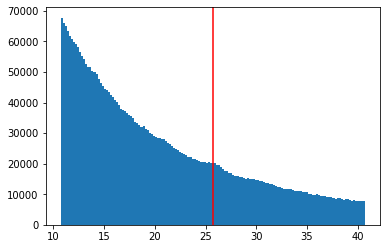

In [45]:
idx = 20
print(snap_list[idx])
freq_list = freq_list_N
ps = ps_N

plt.hist(freq_list[idx][:,2] + 0.5 * freq_list[idx][:,0], bins=np.linspace(ps[idx]-15.0, ps[idx]+15.0, 150))
plt.axvline(ps[idx], c='r')
plt.show()

1000


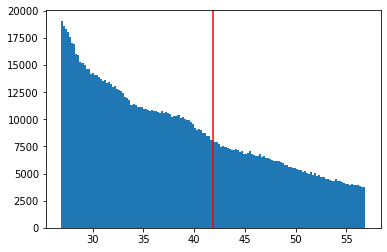

In [160]:
idx = 20
print(snap_list[idx])
freq_list = freq_list_S
ps = ps_S

plt.hist(freq_list[idx][:,2]+ 0.5 * freq_list[idx][:,0], bins=np.linspace(ps[idx]-15.0, ps[idx]+15.0, 150))
plt.axvline(ps[idx], c='r')
plt.show()

In [47]:
from scipy.stats import gaussian_kde
freq_list = freq_list_N
ps = ps_S

kde = gaussian_kde(freq_list[idx][:,2][np.logical_not(np.isnan(freq_list[idx][:,2]))])
x = np.linspace(ps[idx]-15.0, ps[idx]+15.0, 1000)
y = kde(x)

plt.plot(x, y)

KeyboardInterrupt: 

## Capture rate probability stuff

In [80]:
lR = 1
lphi = 2
lz = 0
tol = 0.1

in_CR_N = []
in_CR_S = []

for i,snap in enumerate(tqdm(snap_list)):
    in_CR_N.append(find_stars_res(freq_list_N[i], ps_N[i], lR, lphi, lz, tol=tol))
    in_CR_S.append(find_stars_res(freq_list_S[i], ps_S[i], lR, lphi, lz, tol=tol))

A Jupyter Widget

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [81]:
in_CR_N_num = np.array([len(np.where(in_CR)[0]) for in_CR in in_CR_N])
in_CR_S_num = np.array([len(np.where(in_CR)[0]) for in_CR in in_CR_S])

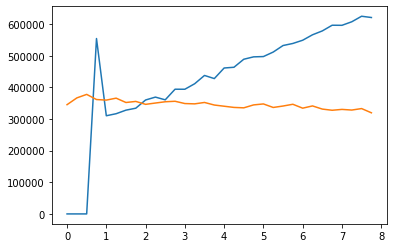

In [82]:
plt.plot(snap_list/200., in_CR_N_num)
plt.plot(snap_list/200., in_CR_S_num)

plt.show()

In [106]:
print(snap_list[28])

1400


In [97]:
len(np.where(np.logical_and(in_CR_N[18], in_CR_N[10]))[0]) / len(np.where(in_CR_N[10])[0])

0.04873758880988512

In [105]:
len(np.where(np.logical_and(in_CR_S[28], in_CR_S[10]))[0]) / len(np.where(in_CR_S[10])[0])

0.5417106443984129

## Angular momentum stuff

In [14]:
print(snap_list[25])

500


In [15]:
Op = ps_S[5]
in_CR = find_stars_res(freq_list_S[5], Op, 0, 2, 0, tol=0.1)

0.47681137690443415


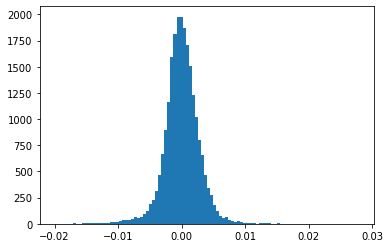

In [31]:
idx = 5
freq_list = freq_list_S
Omega = Omega_S4
ps = ps_S

Op = ps[idx]
in_CR = find_stars_res(freq_list[idx], Op, 0, 2, 0, tol=0.1)

plt.hist(Omega[:,idx,-1][in_CR], bins=100)#, bins=np.linspace(-0.003, 0.003, 600))
print(np.sum(Omega[:,idx,-1][in_CR]))
plt.show()

In [23]:
freq_list_S[5].shape

(3168480, 3)

11.897480018638696


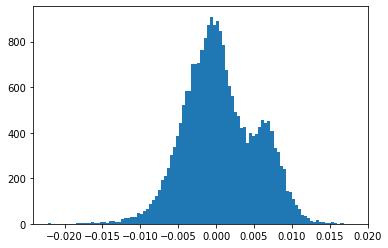

In [128]:
idx = 25
freq_list = freq_list_N
Omega = Omega_N4
ps = ps_N

Op = ps[idx]
in_CR = find_stars_res(freq_list[idx], Op, 0, 2, 0, tol=0.1)

plt.hist(Omega[:,idx,-1][in_CR], bins=100)#, bins=np.linspace(-0.003, 0.003, 600))
print(np.sum(Omega[:,idx,-1][in_CR]))
plt.show()

In [103]:
sn = read_snap(snap_list[25], 0, lvl='lvl4', parttype=1, 
               fields=['Coordinates', 'ParticleIDs', 'Velocities', 'Potential'])

sort = np.argsort(sn.part1.id)

pos = sn.part1.pos.value[sort]
vel = sn.part1.vel.value[sort]
phi = sn.part1.pot.value[sort]

Lz = np.cross(pos, vel)[:,2]
vsq = np.square(np.linalg.norm(vel, axis=1))
mass = sn.MassTable[1]

E = 0.5 * vsq + phi

In [13]:
sn = read_snap(0, 1, lvl='lvl3', parttype=[0, 2])
sn1 = read_snap(1599, 1, lvl='lvl3', parttype=[0, 2])

gas_mass0 = np.sum(sn.part0.mass.value)
gas_mass1 = np.sum(sn1.part0.mass.value)

star_mass0 = sn.NumPart_Total[2] * sn.MassTable[2]

print(gas_mass0 / (gas_mass0 + star_mass0))
print(gas_mass1 / (gas_mass1 + star_mass0))


0.17930500330572224
0.1108205994279109


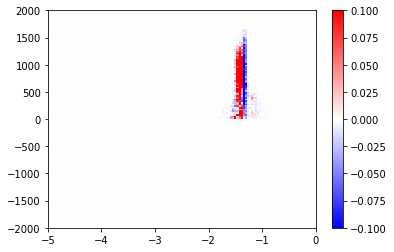

In [104]:
fig, ax = plt.subplots(1, 1)
nres = 128

idx = 25
freq_list = freq_list_N
Omega = Omega_N4
ps = ps_N

Op = ps[idx]
in_CR = find_stars_res(freq_list[idx], Op, 0, 2, 0, tol=0.1)

x = E / 1E5
y = Lz

x = x[in_CR]
y = y[in_CR]

range_xy = [[-5, 0], [-2000, 2000]]

# heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), weights=Omega[in_CR,idx,-1], range=range_xy)

dx = (range_xy[0][1] - range_xy[0][0])/nres
dy = (range_xy[1][1] - range_xy[1][0])/nres
heatmap_xy /= dx * dy

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', cmap='bwr', vmin=-0.1, vmax=0.1)#, norm=mpl.colors.LogNorm())
# im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('auto')
fig.colorbar(im, ax=ax)

plt.show()

In [99]:
sn = read_snap(snap_list[25], 1, lvl='lvl4', parttype=1, 
               fields=['Coordinates', 'ParticleIDs', 'Velocities', 'Potential'])

center = np.array([200., 200., 200.])

sort = np.argsort(sn.part1.id)

pos = sn.part1.pos.value[sort] - center
vel = sn.part1.vel.value[sort]
phi = sn.part1.pot.value[sort]

Lz = np.cross(pos, vel)[:,2]
vsq = np.square(np.linalg.norm(vel, axis=1))
mass = sn.MassTable[1]

E = 0.5 * vsq + phi

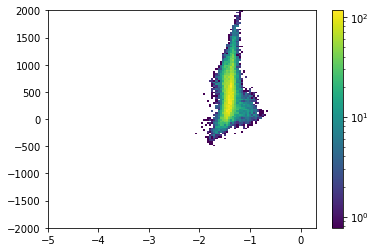

In [116]:
fig, ax = plt.subplots(1, 1)
nres = 128

idx = 5
freq_list = freq_list_S
Omega = Omega_S4
ps = ps_S

Op = ps[idx]
in_CR = find_stars_res(freq_list[idx], Op, 0, 2, 0, tol=0.1)

x = E / 1E5
y = Lz

x = x[in_CR]
y = y[in_CR]

range_xy = [[-5, 0.3], [-2000, 2000]]

heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)
# heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), weights=Omega[in_CR,idx,-1], range=range_xy)

dx = (range_xy[0][1] - range_xy[0][0])/nres
dy = (range_xy[1][1] - range_xy[1][0])/nres
heatmap_xy /= dx * dy

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

# im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', cmap='bwr', vmin=-0.1, vmax=0.1)#, norm=mpl.colors.LogNorm())
im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('auto')
fig.colorbar(im, ax=ax)

plt.show()

In [76]:
E

array([-66762.38926019, -83611.05794939, -32255.90931095, ...,
       -23569.6782571 , -13000.22684101, -57296.97039171])

In [31]:
lRmin = lphimin = lzmin = -7
lRmax = lphimax = lzmax = 7

lRlist = np.arange(lRmin, lRmax+1)
lphilist = np.arange(lphimin, lphimax+1)
lzlist = np.arange(lzmin, lzmax+1)


In [32]:
idx = 25
freq_list = freq_list_N
ps = ps_N

freq = freq_list[idx]
Op = ps[idx]

res_list = []
dLz_list = []
in_res = np.full(len(freq), False)

for lR in tqdm(lRlist):
    for lphi in lphilist:
        for lz in lzlist:
            this_res = find_stars_res(freq, Op, lR, lphi, lz, tol=0.1)
            in_res = np.logical_or(this_res, in_res)

A Jupyter Widget

In [35]:
print(np.sum(Omega_N4[:,idx,-1][in_res]))
print(np.sum(Omega_N4[:,idx,-1]))

83.28882244503859
82.93294055337206


In [33]:
len(np.where(in_res)[0])/len(freq)

0.522782217340807

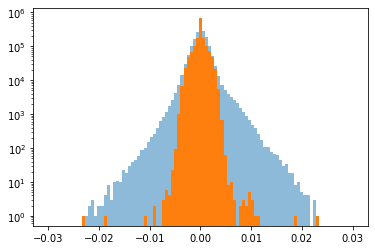

In [46]:
plt.hist(Omega_N4[in_res,idx,-1], bins=np.linspace(-0.03, 0.03, 100), alpha=0.5)
not_in_res = np.logical_not(in_res)
plt.hist(Omega_N4[not_in_res,idx,-1], bins=np.linspace(-0.03, 0.03, 100))
plt.yscale('log')
plt.show()

In [57]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang), np.cos(ang),  0.0],
                     [0.0,         0.0,          1.0]])
    pos = np.swapaxes(pos, 0, 1)

    pos = np.matmul(Rmat, pos)
    
#     w[:3,:] = np.matmul(Rmat, w[:3,:])
#     w[3:,:] = np.matmul(Rmat, w[3:,:])

    pos = np.swapaxes(pos, 0, 1)
    return pos

In [75]:
print(snap_list[10])

500


## x-y positions of CR

In [48]:
idx = 25

sn = read_snap(snap_list[idx], 0, lvl='lvl3', parttype=1, 
               fields=['Coordinates', 'ParticleIDs', 'Velocities', 'Potential'])

sort = np.argsort(sn.part1.id)

pos = sn.part1.pos.value[sort]
vel = sn.part1.vel.value[sort]


In [49]:
freq_list = freq_list_N
# Omega = Omega_N4
ps = ps_N

Op = ps[idx]
in_CR = find_stars_res(freq_list[idx], Op, 0, 2, 0, tol=0.1)

# dLz_cut = Omega[:,idx,-1] > 0.006

zcut = np.abs(pos[:,2]) < 2
in_CR_and_cut = np.logical_and(zcut, in_CR)


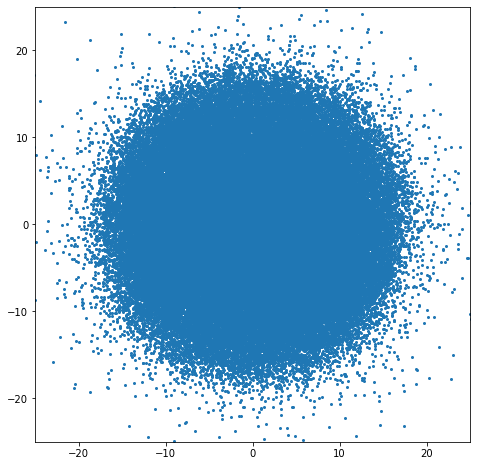

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

L = 25

# ax.scatter(pos[inb_CR,0], pos[in_CR,1], s=1)
ax.scatter(pos[:,0][in_CR_and_cut], pos[:,1][in_CR_and_cut], s=4)
ax.set(xlim=(-L, L), ylim=(-L, L), aspect='equal')
plt.show()

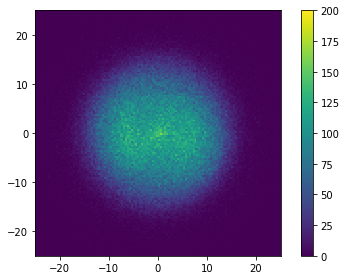

In [51]:
nres = 128

range_xy = [[-L, L], [-L, L]]

x = pos[:,0][in_CR]
y = pos[:,1][in_CR]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=0, vmax=200)#, vmin=10, vmax=1E4, norm=mpl.colors.LogNorm())

fig.colorbar(im, ax=ax)
ax.set_aspect('equal')
fig.tight_layout()


plt.show()


## x-y positions of CR (SMUGGLE)

In [52]:
sn = read_snap(snap_list[25], 1, lvl='lvl3', parttype=1, 
               fields=['Coordinates', 'ParticleIDs', 'Velocities', 'Potential'])

sort = np.argsort(sn.part1.id)
center = np.array([200., 200., 200.])

pos = sn.part1.pos.value[sort] - center
vel = sn.part1.vel.value[sort]


In [53]:
idx = 25
freq_list = freq_list_S
# Omega = Omega_S4
ps = ps_S

Op = ps[idx]
in_CR = find_stars_res(freq_list[idx], Op, 0, 2, 0, tol=0.1)

# dLz_cut = Omega[:,idx,-1] > 0.006

# zcut = np.abs(pos[:,2]) < 1
# in_CR_and_cut = np.logical_and(np.logical_and(zcut, in_CR), dLz_cut)
# in_CR_and_cut = np.logical_and(zcut, in_CR)


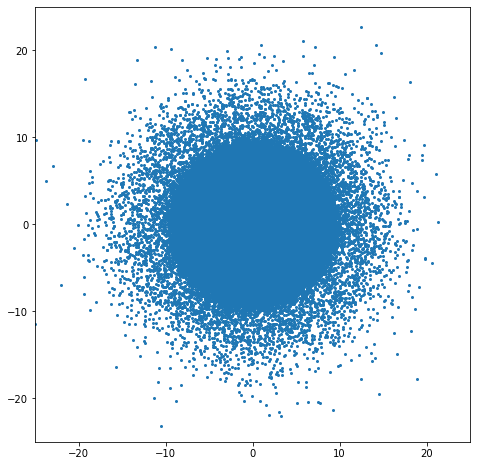

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

L = 25

# ax.scatter(pos[inb_CR,0], pos[in_CR,1], s=1)
ax.scatter(pos[:,0][in_CR], pos[:,1][in_CR], s=4)
ax.set(xlim=(-L, L), ylim=(-L, L), aspect='equal')
plt.show()

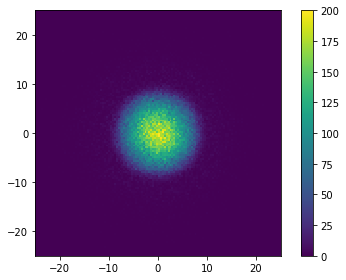

In [55]:
nres = 128

range_xy = [[-L, L], [-L, L]]

x = pos[:,0][in_CR]
y = pos[:,1][in_CR]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=0, vmax=200)#, vmin=10, vmax=1E4, norm=mpl.colors.LogNorm())
fig.colorbar(im, ax=ax)

ax.set_aspect('equal')
fig.tight_layout()

plt.show()


In [67]:
sn = read_snap(snap_list[24], 1, lvl='lvl3', parttype=2, 
               fields=['Coordinates', 'ParticleIDs', 'Velocities', 'Potential'])

sort = np.argsort(sn.part2.id)
center = np.array([200., 200., 200.])

pos = sn.part2.pos.value[sort] - center
vel = sn.part2.vel.value[sort]


In [68]:
idx = 24
freq_list = freq_list_S_disk
Omega = Omega_S4
ps = ps_S

Op = ps[idx]
in_CR = find_stars_res(freq_list[idx], Op, 0, 2, 0, tol=0.1)

# dLz_cut = Omega[:,idx,-1] > 0.006

# zcut = np.abs(pos[:,2]) < 1
# in_CR_and_cut = np.logical_and(np.logical_and(zcut, in_CR), dLz_cut)
# in_CR_and_cut = np.logical_and(zcut, in_CR)


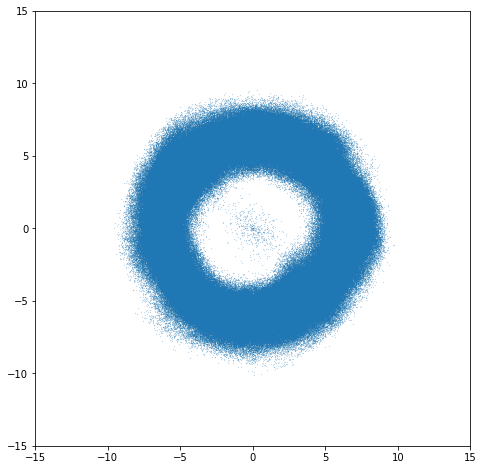

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

L = 15

# ax.scatter(pos[inb_CR,0], pos[in_CR,1], s=1)
ax.scatter(pos[:,0][in_CR], pos[:,1][in_CR], s=0.01)
ax.set(xlim=(-L, L), ylim=(-L, L), aspect='equal')
plt.show()

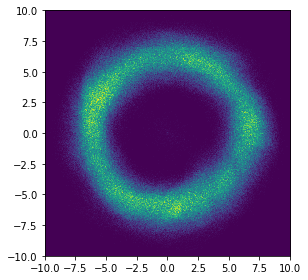

In [70]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = pos[:,0][in_CR]
y = pos[:,1][in_CR]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower')#, vmin=10, vmax=1E4, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


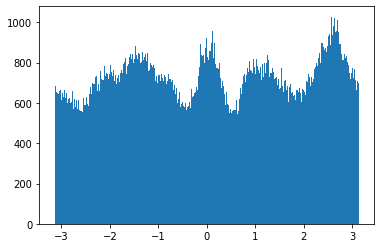

In [71]:
phi = np.arctan2(y, x)
plt.hist(phi, bins=1000)
plt.show()

## x-y positions of disk CR

In [86]:
sn = read_snap(snap_list[19], 0, lvl='lvl3', parttype=2, 
               fields=['Coordinates', 'ParticleIDs', 'Velocities', 'Potential'])

sort = np.argsort(sn.part2.id)

pos = sn.part2.pos.value[sort]
vel = sn.part2.vel.value[sort]

# ba = 66.71908125034574
# pos = rotate_pos(pos, -ba)


In [87]:
print(snap_list[19])

950


In [88]:
idx = 19
freq_list = freq_list_N_disk
ps = ps_N

Op = ps[idx]
in_CR = find_stars_res(freq_list[idx], Op, 0, 2, 0, tol=0.05)

# dLz_cut = Omega[:,idx,-1] > 0.006

# in_CR = np.logical_and(in_CR, dLz_cut)

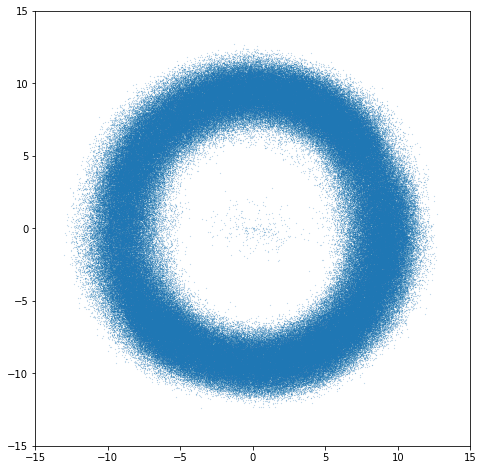

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

L = 15

ax.scatter(pos[in_CR,0], pos[in_CR,1], s=0.01)
ax.set(xlim=(-L, L), ylim=(-L, L), aspect='equal')
plt.show()

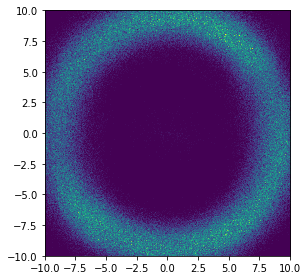

In [90]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = pos[:,0][in_CR]
y = pos[:,1][in_CR]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower')#, vmin=10, vmax=1E4, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


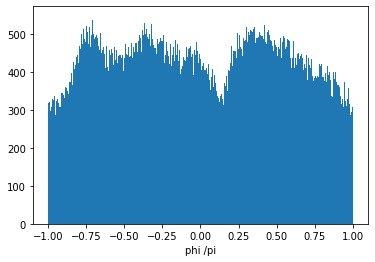

In [91]:
phi = np.arctan2(y, x)
plt.hist(phi/np.pi, bins=1000)
plt.xlabel('phi /pi')
plt.show()

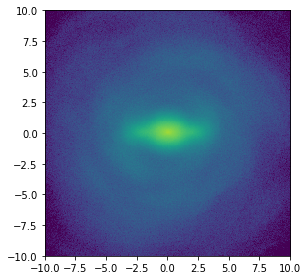

In [66]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = pos[:,0]
y = pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=10, vmax=1E4, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


## Lz hist

In [16]:
print(snap_list[10])
sn = read_snap(snap_list[10], 0, lvl='lvl3', parttype=1, 
               fields=['Coordinates', 'ParticleIDs', 'Velocities', 'Potential'])

pos = sn.part1.pos.value
vel = sn.part1.vel.value
phi = sn.part1.pot.value

Lz = np.cross(pos, vel)[:,2]
E = phi + 0.5 * np.square(np.linalg.norm(vel, axis=1))
Ltot = np.linalg.norm(np.cross(pos, vel), axis=1)

500


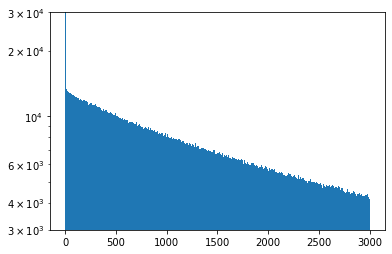

In [38]:
plt.hist(Lz, bins=np.linspace(0, 3000, 1000))
# plt.ylim(0, 1000)
plt.yscale('log')
plt.ylim(3E3, 3E4)
plt.show()

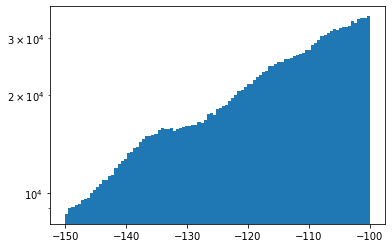

In [39]:
plt.hist(E/1000.0, bins=np.linspace(-150, -100, 100))
# plt.ylim(0, 1000)
plt.yscale('log')
plt.show()

In [25]:
key = np.argmin(np.linalg.norm(pos - np.array([6.5, 0, 0]), axis=1))
print(phi[key])
print(phi[key] + 0.5 * 200*200)

-165308.02747588995
-145308.02747588995


In [5]:
def get_E_Lz(idx, sim_idx):
    sn = read_snap(idx, sim_idx, lvl='lvl3', parttype=1, 
               fields=['Coordinates', 'ParticleIDs', 'Velocities', 'Potential'])

    center = np.array([200., 200., 200.])

    pos = sn.part1.pos.value - center
    vel = sn.part1.vel.value
    phi = sn.part1.pot.value

    E = phi + 0.5 * np.square(np.linalg.norm(vel, axis=1))
    Lz = np.cross(pos, vel)[:,2]
    Ltot = np.linalg.norm(np.cross(pos, vel), axis=1)
    
    return E, Lz

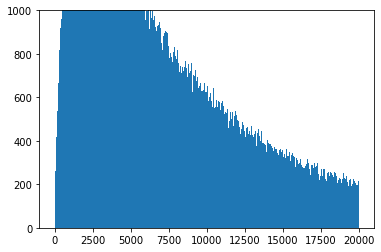

In [80]:
plt.hist(Lz[Lz/Ltot > 0.95], bins=np.linspace(0, 20000, 1000))
plt.ylim(0, 1000)
plt.yscal
plt.show()

In [111]:
E0, Lz0 = get_E_Lz(snap_list[0], 1)
E10, Lz10 = get_E_Lz(snap_list[10], 1)
E10_N, _ = get_E_Lz(snap_list[10], 0)
E20, Lz20 = get_E_Lz(snap_list[20], 1)
E30, Lz30 = get_E_Lz(snap_list[30], 1)

In [33]:
def read_agama_pot(idx, name, lvl):
    base = '/n/home01/abeane/starbar/plots/agama_pot/data/'
    fname = base + 'pot_' + name + '-' + lvl + '/pot_' + name + '-' + lvl + '.' + str(idx) + '.txt'
    return agama.Potential(fname)

In [112]:
pot0 = read_agama_pot(snap_list[0], 'phantom-vacuum-Sg20-Rc3.5', 'lvl3')
pot10 = read_agama_pot(snap_list[10], 'phantom-vacuum-Sg20-Rc3.5', 'lvl3')
pot20 = read_agama_pot(snap_list[20], 'phantom-vacuum-Sg20-Rc3.5', 'lvl3')
pot30 = read_agama_pot(snap_list[30], 'phantom-vacuum-Sg20-Rc3.5', 'lvl3')

In [35]:
from scipy.optimize import minimize

def _to_minimize(E, Op, pot):
    return np.abs((Op - 2.*np.pi/pot.Tcirc(E)))

def compute_E_CR(pot, Op):
    ans = minimize(_to_minimize, -1E5, args=(Op, pot))
    return ans.x[0]

In [116]:
ECR_0 = compute_E_CR(pot0, ps_S[0])
ECR2_0 = compute_E_CR(pot0, ps_S[0]/2.0)
ECR_10 = compute_E_CR(pot10, ps_S[10])
ECR2_10 = compute_E_CR(pot10, ps_S[10]/2.0)
ECR_20 = compute_E_CR(pot20, ps_S[20])
ECR2_20 = compute_E_CR(pot20, ps_S[20]/2.0)
ECR_30 = compute_E_CR(pot30, ps_S[30])
ECR2_30 = compute_E_CR(pot30, ps_S[30]/2.0)

/n/home01/abeane/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))


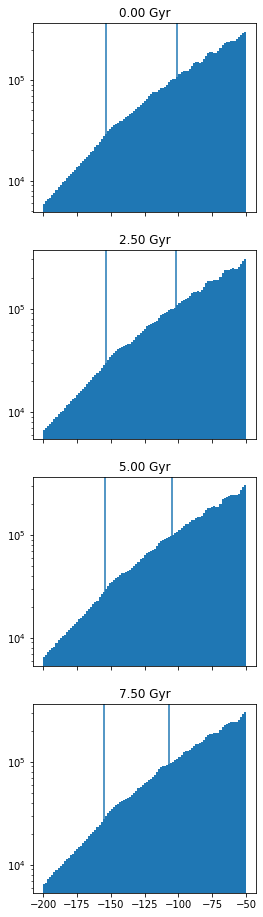

In [119]:
fig, ax = plt.subplots(4, 1, figsize=(4, 16), sharex=True)
bins = np.linspace(-200, -50, 100)

ax[0].hist(E0/1000.0, bins=bins)
ax[0].axvline(ECR_0/1000.0)
ax[0].axvline(ECR2_0/1000.0)
ax[0].set_title("{:.02f} Gyr".format(snap_list[0]/200.0))

ax[1].hist(E10/1000.0, bins=bins)
ax[1].axvline(ECR_10/1000.0)
ax[1].axvline(ECR2_10/1000.0)
ax[1].set_title("{:.02f} Gyr".format(snap_list[10]/200.0))

ax[2].hist(E20/1000.0, bins=bins)
ax[2].axvline(ECR_20/1000.0)
ax[2].axvline(ECR2_20/1000.0)
ax[2].set_title("{:.02f} Gyr".format(snap_list[20]/200.0))

ax[3].hist(E30/1000.0, bins=bins)
ax[3].axvline(ECR_30/1000.0)
ax[3].axvline(ECR2_30/1000.0)
ax[3].set_title("{:.02f} Gyr".format(snap_list[30]/200.0))

# plt.ylim(0, 1000)
for x in ax:
    x.set_yscale('log')

plt.show()

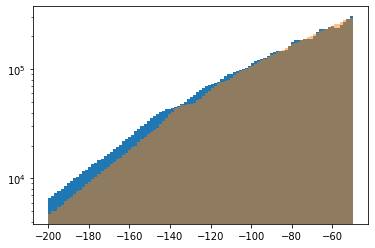

In [23]:
plt.hist(E10/1000.0, bins=bins)
plt.hist(E10_N/1000.0, bins=bins, alpha=0.5)

plt.yscale('log')
plt.show()

In [53]:
def read_agama_pot(idx, name, lvl):
    base = '/n/home01/abeane/starbar/plots/agama_pot/data/'
    fname = base + 'pot_' + name + '-' + lvl + '/pot_' + name + '-' + lvl + '.' + str(idx) + '.txt'
    return agama.Potential(fname)

In [82]:
from scipy.optimize import minimize

def _to_minimize(E, Op, pot):
    return np.abs((Op - 2.*np.pi/pot.Tcirc(E)))

def compute_E_CR(pot, Op):
    ans = minimize(_to_minimize, -1E5, args=(Op, pot))
    return ans.x[0]

In [121]:
E10, Lz10 = get_E_Lz(snap_list[10], 0)
E20, Lz20 = get_E_Lz(snap_list[20], 0)
E30, Lz30 = get_E_Lz(snap_list[30], 0)

pot10 = read_agama_pot(snap_list[10], 'Nbody', 'lvl3')
pot20 = read_agama_pot(snap_list[20], 'Nbody', 'lvl3')
pot30 = read_agama_pot(snap_list[30], 'Nbody', 'lvl3')

ECR_10 = compute_E_CR(pot10, ps_N[10])
ECR_20 = compute_E_CR(pot20, ps_N[20])
ECR_30 = compute_E_CR(pot30, ps_N[30])

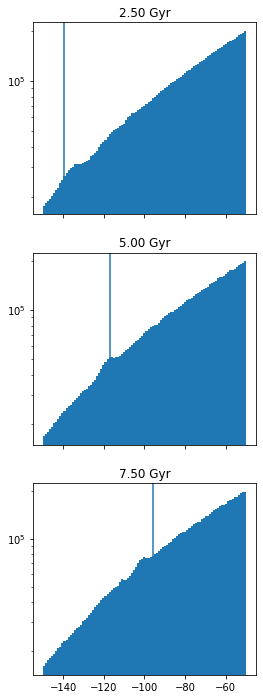

In [122]:
fig, ax = plt.subplots(3, 1, figsize=(4, 12), sharex=True)
bins = np.linspace(-150, -50, 100)

ax[0].hist(E10/1000.0, bins=bins)
ax[0].axvline(ECR_10/1000.0)
ax[0].set_title("{:.02f} Gyr".format(snap_list[10]/200.0))


ax[1].hist(E20/1000.0, bins=bins)
ax[1].axvline(ECR_20/1000.0)
ax[1].set_title("{:.02f} Gyr".format(snap_list[20]/200.0))


ax[2].hist(E30/1000.0, bins=bins)
ax[2].axvline(ECR_30/1000.0)
ax[2].set_title("{:.02f} Gyr".format(snap_list[30]/200.0))


# plt.ylim(0, 1000)
for x in ax:
    x.set_yscale('log')

plt.show()

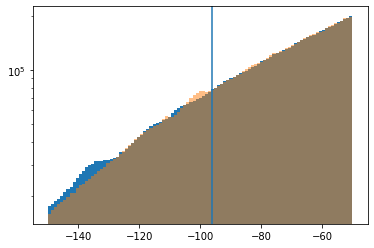

In [26]:
plt.hist(E10/1000.0, bins=bins)
plt.hist(E30/1000.0, bins=bins, alpha=0.5)
plt.axvline(ECR_30/1000.0)

plt.yscale('log')
plt.show()

## Looking at distribution of one E hump

In [157]:
print(snap_list[1])
sn = read_snap(1400, 1, lvl='lvl3', parttype=1, 
               fields=['Coordinates', 'ParticleIDs', 'Velocities', 'Potential'])
center = np.array([200., 200., 200.])

pos = sn.part1.pos.value - center
vel = sn.part1.vel.value
phi = sn.part1.pot.value

Lz = np.cross(pos, vel)[:,2]
E = phi + 0.5 * np.square(np.linalg.norm(vel, axis=1))
Ltot = np.linalg.norm(np.cross(pos, vel), axis=1)

50


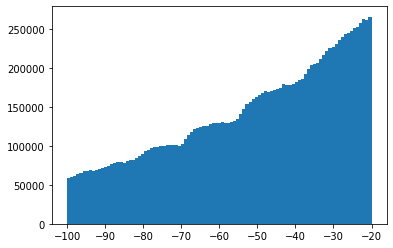

In [159]:
bins = np.linspace(-100, -20, 100)
plt.hist(E/1000.0, bins=bins)

# plt.axvline(-70)
# plt.axvline(-80)

plt.show()

In [ ]:
nres = 128
key = np.logical_and(E/1000.0 > -80, E/1000.0 < -70)

range_xy = [[-40, 40], [-40, 40]]

x = pos[:,0][key]
y = pos[:,1][key]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=10, vmax=100)#, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


In [136]:
print(snap_list[20])
sn = read_snap(snap_list[20], 0, lvl='lvl3', parttype=1, 
               fields=['Coordinates', 'ParticleIDs', 'Velocities', 'Potential'])
center = np.array([200., 200., 200.])
posN = sn.part1.pos.value
velN = sn.part1.vel.value
phiN = sn.part1.pot.value

LzN = np.cross(posN, velN)[:,2]
EN = phiN + 0.5 * np.square(np.linalg.norm(velN, axis=1))
# Ltot = np.linalg.norm(np.cross(pos, vel), axis=1)

1000


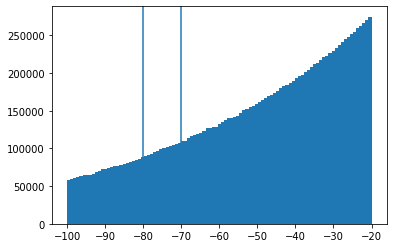

In [137]:
bins = np.linspace(-100, -20, 100)
plt.hist(EN/1000.0, bins=bins)

plt.axvline(-70)
plt.axvline(-80)

plt.show()

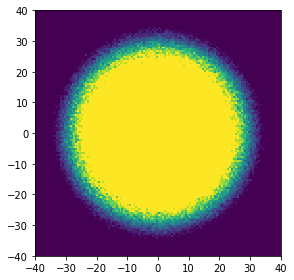

In [146]:
nres = 128
key = np.logical_and(EN/1000.0 > -80, EN/1000.0 < -70)

range_xy = [[-40, 40], [-40, 40]]

x = posN[:,0][key]
y = posN[:,1][key]
heatmap_xy_N, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy_N.T, extent=extent, origin='lower', vmin=10, vmax=100)#, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


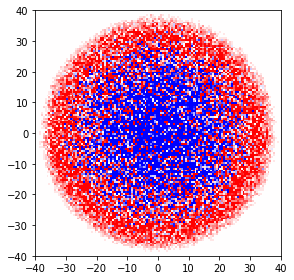

In [147]:
fig, ax = plt.subplots(1, 1)

ax.imshow((heatmap_xy - heatmap_xy_N).T, extent=extent, origin='lower', vmin=-10, vmax=10, cmap='bwr')#, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()

## E-Lz plot

In [123]:
def get_E_Lz_Ltot(idx, sim_idx, Nbody=False):
    sn = read_snap(idx, sim_idx, lvl='lvl3', parttype=1, 
               fields=['Coordinates', 'ParticleIDs', 'Velocities', 'Potential'])

    if Nbody:
        center = np.array([0., 0., 0.])
    else:
        center = np.array([200., 200., 200.])

    pos = sn.part1.pos.value - center
    vel = sn.part1.vel.value
    phi = sn.part1.pot.value

    E = phi + 0.5 * np.square(np.linalg.norm(vel, axis=1))
    Lz = np.cross(pos, vel)[:,2]
    Ltot = np.linalg.norm(np.cross(pos, vel), axis=1)
    
    return E, Lz, Ltot

In [125]:
EN, LzN, LtotN = get_E_Lz_Ltot(snap_list[10], 0, Nbody=True)

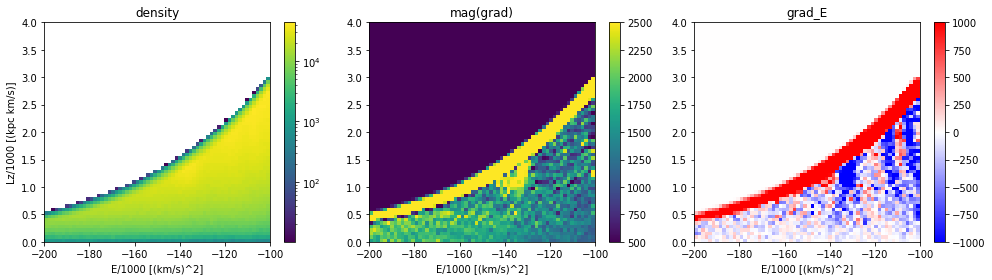

In [132]:
nres = 64

range_xy = [[-200, -100], [0, 4]]


x = EN/1000.0
y = LtotN/1000.0
heatmap_xy_N, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

dx = (range_xy[0][-1] - range_xy[0][0])/nres
dy = (range_xy[1][-1] - range_xy[1][0])/nres
heatmap_xy_N /= dx * dy

fig, ax = plt.subplots(1, 3, figsize=(14, 4))

im = ax[0].imshow(heatmap_xy_N.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax[0].set_aspect('auto')
fig.colorbar(im, ax=ax[0])

gradx, grady = np.gradient(heatmap_xy_N)
grad_magN = np.sqrt(gradx*gradx + grady*grady)
im = ax[1].imshow(grad_magN.T, extent=extent, origin='lower', vmin=500, vmax=2500)#, vmin=1, vmax=100)#, norm=mpl.colors.LogNorm())
ax[1].set_aspect('auto')
fig.colorbar(im, ax=ax[1])

im = ax[2].imshow(gradx.T, extent=extent, origin='lower', cmap='bwr', vmin=-1000, vmax=1000)
fig.colorbar(im, ax=ax[2])
ax[2].set_aspect('auto')

ax[0].set_title('density')
ax[1].set_title('mag(grad)')
ax[2].set_title('grad_E')

for x in ax:
    x.set_xlabel('E/1000 [(km/s)^2]')

ax[0].set_ylabel('Lz/1000 [(kpc km/s)]')

fig.tight_layout()

plt.show()


In [128]:
E, Lz, Ltot = get_E_Lz_Ltot(snap_list[30], 1, Nbody=False)

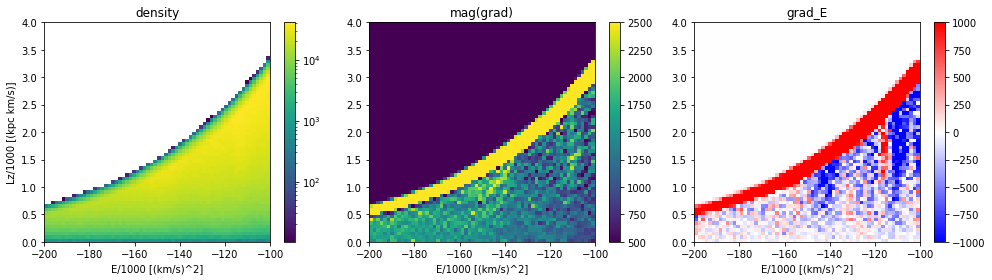

In [133]:
nres = 64

range_xy = [[-200, -100], [0, 4]]

x = E/1000.0
y = Ltot/1000.0
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

dx = (range_xy[0][-1] - range_xy[0][0])/nres
dy = (range_xy[1][-1] - range_xy[1][0])/nres
heatmap_xy /= dx * dy

fig, ax = plt.subplots(1, 3, figsize=(14, 4))

im = ax[0].imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax[0].set_aspect('auto')
fig.colorbar(im, ax=ax[0])

gradx, grady = np.gradient(heatmap_xy)
grad_mag = np.sqrt(gradx*gradx + grady*grady)
im = ax[1].imshow(grad_mag.T, extent=extent, origin='lower', vmin=500, vmax=2500)#, norm=mpl.colors.LogNorm())
ax[1].set_aspect('auto')
fig.colorbar(im, ax=ax[1])

im = ax[2].imshow(gradx.T, extent=extent, origin='lower', cmap='bwr', vmin=-1000, vmax=1000)
fig.colorbar(im, ax=ax[2])
ax[2].set_aspect('auto')

ax[0].set_title('density')
ax[1].set_title('mag(grad)')
ax[2].set_title('grad_E')

for x in ax:
    x.set_xlabel('E/1000 [(km/s)^2]')

ax[0].set_ylabel('Lz/1000 [(kpc km/s)]')

fig.tight_layout()

plt.show()


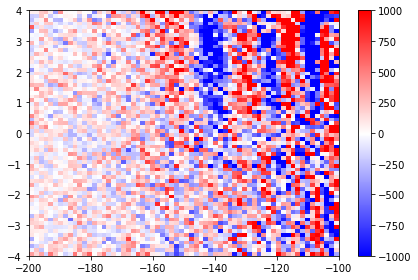

In [130]:
nres = 64

range_xy = [[-200, -100], [-4, 4]]

x = E/1000.0
y = Lz/1000.0
heatmap_xy_N, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

im = ax.imshow((grad_mag - grad_magN).T, extent=extent, origin='lower', vmin=-1000, vmax=1000, cmap='bwr')#, norm=mpl.colors.LogNorm())
ax.set_aspect('auto')
fig.colorbar(im, ax=ax)

fig.tight_layout()

plt.show()
